In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [6]:
# Import and establish Base for which classes will be constructed 
Base = automap_base()

In [7]:
# reflect an existing database into a new model
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
m = Base.classes.measurement
s = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
first_row = session.query(s).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x18452350708>,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'longitude': -157.8168}

In [12]:
first_row = session.query(m).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x184523a3448>,
 'station': 'USC00519397',
 'tobs': 65.0,
 'prcp': 0.08,
 'date': '2010-01-01',
 'id': 1}

In [13]:
 engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

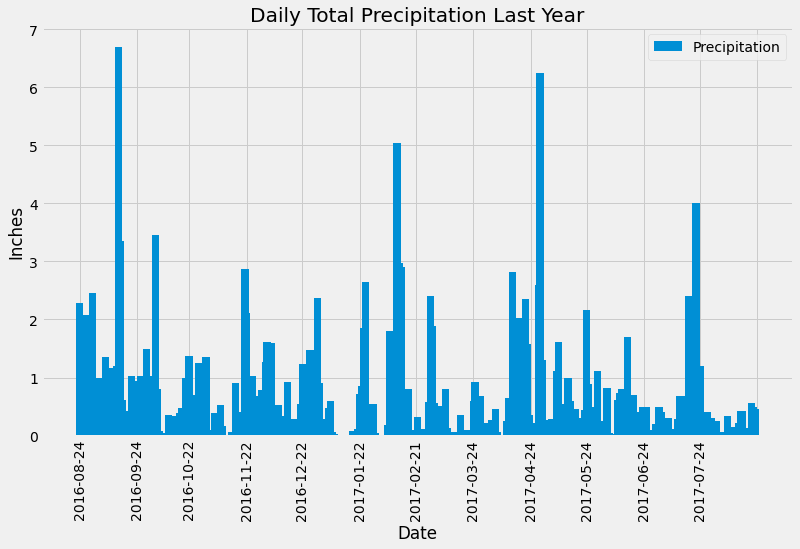

In [20]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(func.max(m.date)).first()
query_date = datetime.strptime(last_date[0], "%Y-%m-%d")
query_date = query_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
result = session.query(m.date, m.prcp).filter(m.date >= query_date).all()

# Save the query results as a Pandas DataFrame
prcp_last_year = pd.DataFrame(result, columns=['date', 'prcp'])

# Sort the dataframe by date
prcp_last_year = prcp_last_year.sort_values('date')



# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(12, 7))

# Add x-axis and y-axis
ax.bar(prcp_last_year.date,
       prcp_last_year.prcp,
       label= "Precipitation",
       width=4)

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Inches",
       title="Daily Total Precipitation Last Year")

# Set legend
ax.legend()

# Set xaxis ticks
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_tick_params(rotation=90)

plt.show()

In [115]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_last_year['prcp'].describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

In [121]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(m).group_by(m.station).count()
print(f"Number of stations available is: {station_count}")

Number of stations available is: 9


In [34]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_list = session.query(m.station, s.name, func.count(m.station)) \
                      .filter(m.station == s.station) \
                      .group_by(m.station) \
                      .order_by(func.count(m.station).desc()).all()
station_list

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [42]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
min_temp = session.query(func.min(m.tobs)) \
                      .filter(m.station == station_list[0][0]).all()
max_temp = session.query(func.max(m.tobs)) \
                      .filter(m.station == station_list[0][0]).all()
avg_temp = session.query(func.avg(m.tobs)) \
                      .filter(m.station == station_list[0][0]).all()

print(f"Temperature observation data (TOBS) at Station {station_list[0][1]}\n \
        Lowest Temperature: {min_temp[0][0]}\n \
        Highest Temperature: {max_temp[0][0]}\n \
        Average Temperature: {round(avg_temp[0][0],2)}")

Temperature observation data (TOBS) at Station WAIHEE 837.5, HI US
         Lowest Temperature: 54.0
         Highest Temperature: 85.0
         Average Temperature: 71.66


In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
